# Coupled flow/elastic flexure ice shelf model
This notebook couples a slightly modified SSA [(MacAyeal et al., 2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) with the Kirchhoff plate equations, allowing the approach of a steady-state ice shelf profile under both horizontal viscous flow and vertical elastic deflection. Equations are solved using Firedrake and [icepack](https://github.com/icepack/icepack). Beginning with a shelf in isostatic equilibrium with seawater, the workflow is as follows:

## Workflow

1) **Solve the SSA to obtain a velocity field**
    - this is the modified version from Equation 44 in MacAyeal et al. 
    - see also my [modified SSA notebook](https://github.com/chrismiele/weird_flex/blob/main/flow/modified_SSA.ipynb)<br>
    <br>
2) **Adjust the surface elevation and basal elevation via dynamic thinning only**
    - adjust shelf geometry under *zero surface mass balance* (mass balance will be applied in Step 4)
    - dynamically thin the submarine and subaerial parts of the shelf separately
    - this allows us to track the dynamic evolution of surface and basal elevation without assuming equilibrium <br>
    <br>
3) **Solve the Kirchhoff equations to flex the shelf**
    - load relates to surface mass balance and velocity field as outlined in Eq. 57 of MacAyeal et al.
    - see also my [elastic Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/flexure/kirchhoff_plate_elastic.ipynb)
    - in this step, we calculate the vertical deflection η and update the accumulated vertical deflections $\Sigma η$ <br>
    <br>
4) **Adjust geometry and return to (1)**
    - now use mass balance $\dot{a}$ and deflection η to modify surface elevation, via ```s = s + aΔt + η```
    - with no basal mass balance component, ```b = b + η```

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figs

from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 200, 1 #number of elements in x, y
Lx, Ly = 6000, 6000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection
w = TestFunction(Q1)
ddw = grad(grad(w))
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
E = 1e9 #Young's Modulus in Pascals
μ = 1/3 #Poisson's Ratio
λ_1 = E/(1 + μ) #convenient shorthand variable
λ_2 = E/(1 + μ)*μ/(1 - μ) #convenient shorthand variable
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law

H_gl = 100 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    ν = 1/2*A**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

## Set up the solver

We'll apply the flow-flexure model to the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries in the flow solver to be ```side_wall_ids``` with friction coefficient zero. 

To provide a load for the flexure solver, surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve (see figure below). 

Because the constitutive relation for elastic flexure relates forcing to the net vertical displacement (rather than just the displacement calculated at each individual time step), it is necessary to keep track of the deflection field over time. We advect the net deflection downstream using icepack's Damage Transport module. 

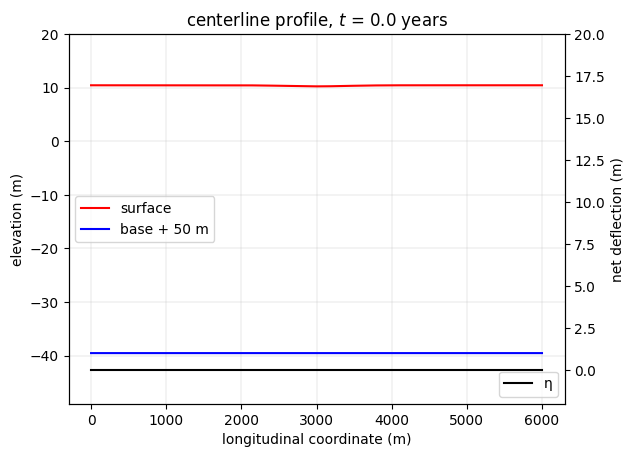

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/10 #length of timestep in years
num_timesteps = int(40/Δt) #spin up for 40 years

##################################
##################################
### parameters for flow solver ###
##################################
##################################

ux_gl = 100 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2, #model is icepack's SSA, but with our own physics
                                 side_friction = icepack.models.friction.side_friction)

flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
a_x = 2*exp(-1/2*((x - Lx/2)/400)**2) #impose an ablation rate (m/yr) as a gaussian curve
a = project(-a_x, Q2) 

η_transport_model = icepack.models.DamageTransport(damage_rate = 0.0, healing_rate = 0.0) #for advecting the accumulated deflection field
η_transport_solver = icepack.solvers.DamageSolver(η_transport_model)

#############################
#############################
### plot initial geometry ###
#############################
#############################

os.chdir(path) #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
s0 = project(s0 + a*Δt, Q2)
H0 = project(s0 - b0, Q2)
s0_profile = s0.at(X, tolerance = 1e-10)
b0_profile = np.array(project(b0 + 50, Q2).at(X, tolerance = 1e-10)) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s0_profile, color='red', label = 'surface')
plt.plot(b0_profile, color='blue', label = 'base + 50 m')
plt.legend(loc = 'center left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl - H_gl/10) + 50, int((1 - ϱ)*H_gl + H_gl/10))
plt.xticks(np.arange(0, Lx+1, 1000))
plt.grid(linewidth=0.2)
plt.twinx()
plt.ylabel('net deflection (m)')
plt.ylim(-2, 20)
plt.plot((0, 6000), (0, 0), color='k', label = 'η')
plt.legend(loc='lower right')
plt.savefig('iteration_0')

## Iteratively solve the flow-flexure problem

To iterate through, we need to keep track of the net deflection accumulated across each previous timestep. This is because the elastic Kirchhoff plate equations relate the stresses in the shelf to total deflection (as opposed to a deflection rate). Therefore, we will define a variable ```Ση``` to represent the accumulated deflection up to the most recent time step, and solve for the next iteration of ```η```. 

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]


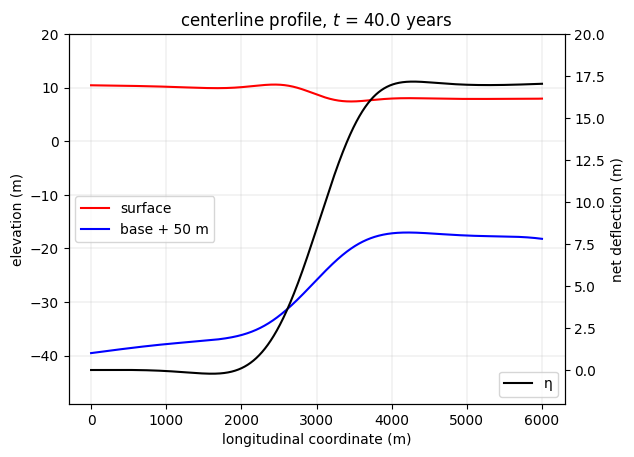

In [8]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
Ση = 0 #accumulated deflection of the shelf up to the most recent time step

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = s0, accumulation = Constant(0))
    
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = b0, accumulation = Constant(0))
    
    H = s - b

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ν = effective_viscosity(velocity = u) #in Pa*yrs, for consistency with icepack's velocity units
    ε = sym(grad(u)) #strain rate tensor, /yr
    τ = 2*ν*ε #depth-averaged deviatoric stress tensor in Pascals
    p = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - p*Identity(2) #depth-averaged net stress 

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s + a*Δt + η - (1 - ϱ)*(H + a*Δt) #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    f += H*inner(σ, grad(grad(η))) #Eq. 57e

    L = (λ_1*H**3/12*inner(grad(grad(η + Ση)), ddw))*dx + λ_2*H**3/12*div(grad(η + Ση))*Δw*dx - f*w*dx #note the use of Ση + η
    L += 0.5*α**2*grad(η)[1]*grad(w)[1]*dx #dη/dy = 0 everywhere
    L += 0.5*α**2*h_ab*w*ds(1) #constrain h_ab = 0 on the boundary
    L += 0.5*α**2*h_ab*w*ds(2)
    
    solve(L == 0, η)

    ###############################################
    ###############################################
    ### update and transport the net deflection ###
    ###############################################
    ###############################################

    translate = 10 #how far do we need to vertically translate to ensure Ση >= 0?
    scale = 100 #how much do we need to squish to ensure Ση <= 1?
    Ση = project((Ση + η + translate)/scale, Q2) #map Ση onto values in [0, 1] (to trick icepack into thinking of Ση as "damage")
    
    Ση = η_transport_solver.solve(Δt, damage = Ση, velocity = u, #transport Ση with flow
                                    strain_rate = Function(S).project(Identity(2)), #this parameter is irrelevant here
                                    membrane_stress = Function(S).project(Identity(2)), #also this one
                                    damage_inflow = Ση)
    
    Ση = project(Ση*scale - translate, Q1) #map Ση back to its proper values

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η, Q2) #b is modified by the new deflection
    s = project(s + a*Δt + η, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #thickness

    #################################################
    #################################################
    ### make sure nothing has gone horribly wrong ###
    #################################################
    #################################################
    
    #if we've imposed too much surface melt, the surface may dip below the waterline
    #this breaks the mass conservation equations
    
    if s.dat.data.min() < 0: #if s < 0 anywhere:
        print('the surface went underwater! that sucks!')
        break
        
    #################
    #################
    ### save figs ###
    #################
    #################

    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 50, Q2).at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10 + 50, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='red', label = 'surface')
    plt.plot(b_profile, color='blue', label = 'base + 50 m')
    plt.grid(linewidth = 0.2)
    plt.legend(loc = 'center left')
    plt.twinx()
    plt.plot(project(Ση, Q2).at(X, tolerance = 1e-10), color='k', label = 'η')
    plt.ylabel('net deflection (m)')
    plt.ylim(-2, 20)
    plt.legend(loc = 'lower right')
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration